In [1]:
import numpy as np
from numpy import random as rd
import time
import matplotlib.pyplot as plt
from solvers_listos import *
from funciones import *
from demandas import *

In [2]:
def SEDA(datos, historia=False, alpha=0.1, beta=0.1, theta=0.5):
    """
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicamente el Método de Holt Damped.
    """
    I = [datos[0]]
    S = [datos[1] - datos[0]]
    for i in range(1, len(datos)):
        I.append(alpha * datos[i] + (1 - alpha) * (I[i - 1] + theta * S[i - 1]))
        S.append(beta * (I[i] - I[i - 1]) + (1 - beta) * S[i - 1])

    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == "S":
        return I, S


def pronostico_SEDA(datos, T, pron=False, alpha=0.1, beta=0.1, theta=0.5):
    """
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    """
    I, S = SEDA(datos, historia="S", alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha * y + (1 - alpha) * (I[-1] + theta * S[-1]))
        S.append(beta * (I[-1] - I[-2]) + (1 - beta) * S[-1])

    return pronostico


In [13]:
#TERMINAR DE HACER EL PRONOSTICO PARA TODOS LOS NODOS

def calibrar_pronostico(G, historia, tiempo, verbose = False):
    best = {}
    for nodo in G.nodes():
        if nodo != 'N_0':
            best_nodo = [0,0,0,100]
            for i in range(1,10):
                for j in range(1,10):
                    ap = i/10
                    bt = j/10
                    th = 0.5
                    error = []
                    for t in tiempo:
                        d_real = historia[nodo][t]
                        pron = pronostico_SEDA(historia[nodo], T = 3, pron = True, alpha = ap, beta= bt, theta=th)[0]
                        error_t = 100*abs(d_real - pron)/d_real
                        error.append(error_t)
                    if np.mean(error) < best_nodo[3]:
                        best_nodo = [ap,bt,th,np.mean(error)]
                        if verbose == True:
                            print(f'alpha = {ap}, beta = {bt}, theta = {th}, error = {np.mean(error)}%')
            if verbose == True:
                print(f'Nodo {nodo}: {best_nodo}')
            best[nodo] = best_nodo
    return best
                    

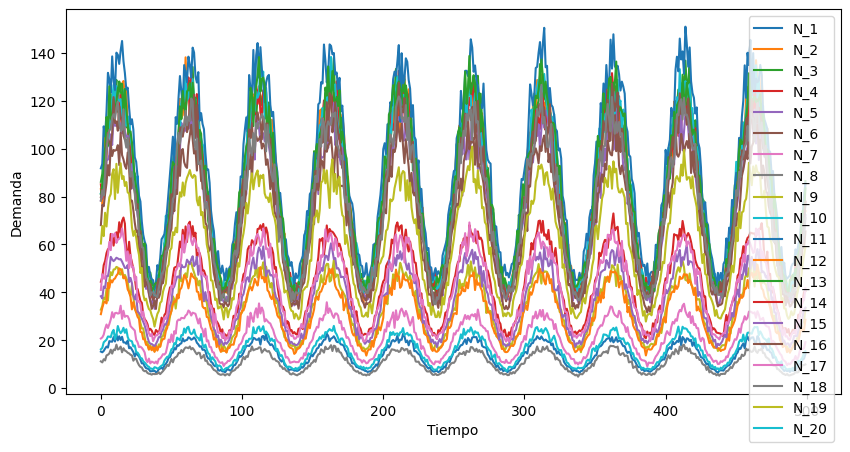

In [67]:
#Instancia de prueba
np.random.seed(3)
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo='n20estandar.xlsx', plot=False)

depots = [nodo for nodo in G.nodes() if nodo != 'N_0']

T = 500
tpo = np.arange(0,T,1)
T_entreno = 100
tpo_historia = np.arange(0,T_entreno,1)
F = 1

datos = simular_demanda_previa(G, dist = 'o', T=T, d = 50, plot=True) #Simular demanda previa
historia = {_:datos[_][:100] for _ in datos.keys()}

mu_demanda = {nodo: np.mean(historia[nodo]) for nodo in historia.keys()}
sd_demanda = {nodo: np.std(historia[nodo]) for nodo in historia.keys()}

In [68]:
# Calibración de parámetros
params_pron = calibrar_pronostico(G, historia, tpo_historia)

In [69]:
params_pron

{'N_1': [0.1, 0.7, 0.5, 33.812227688366804],
 'N_2': [0.1, 0.9, 0.5, 33.61404041514648],
 'N_3': [0.1, 0.6, 0.5, 32.88917432037913],
 'N_4': [0.1, 0.6, 0.5, 33.79959764752814],
 'N_5': [0.1, 0.9, 0.5, 34.43626226271974],
 'N_6': [0.2, 0.2, 0.5, 32.83558953389927],
 'N_7': [0.2, 0.2, 0.5, 33.786434689720046],
 'N_8': [0.2, 0.2, 0.5, 33.368915954269845],
 'N_9': [0.1, 0.9, 0.5, 33.63724754254116],
 'N_10': [0.1, 0.9, 0.5, 33.75005191446481],
 'N_11': [0.1, 0.9, 0.5, 33.650588457424575],
 'N_12': [0.2, 0.2, 0.5, 33.81417162648367],
 'N_13': [0.1, 0.5, 0.5, 32.63520085697123],
 'N_14': [0.2, 0.2, 0.5, 32.93582171326341],
 'N_15': [0.1, 0.9, 0.5, 32.7971553468129],
 'N_16': [0.1, 0.5, 0.5, 33.28203088892088],
 'N_17': [0.1, 0.7, 0.5, 33.520339173570235],
 'N_18': [0.2, 0.2, 0.5, 33.14511258771067],
 'N_19': [0.1, 0.8, 0.5, 33.61980700738857],
 'N_20': [0.2, 0.1, 0.5, 33.3213390196988]}

In [70]:
# Comparación entre pronóstico, media y demanda real

# nodo = 'N_1'

data = {_: None for _ in depots}

for nodo in G.nodes():
    if nodo != 'N_0':
        demandas = {'R': [], 'P': []}
        error = []
        error_mu = []

        mu = np.mean(historia[nodo])
        sd = np.std(historia[nodo])
        ap, bt, th, _ = params_pron[nodo]

        for t in tpo:
            if t < T_entreno:
                d_real = datos[nodo][t]
                pron = None
            else:
                d_real = datos[nodo][t]
                pron = pronostico_SEDA(historia[nodo], T = 1, pron = True, alpha=ap, beta=bt, theta=th)[0]
                error_t = 100*abs(d_real - pron)/d_real
                error_media = 100*abs(d_real - mu)/d_real
                historia[nodo].append(d_real)
                error.append(error_t)
                error_mu.append(error_media)
                # if t%10 == 0:
                    # print(f"t = {t-T_entreno}, d_real = {round(d_real,3)}, pron = {round(pron,3)}, error = {round(error_t,3)}%")
                # print(f"t = {t-T_entreno}, d_real = {round(d_real,3)}, pron = {round(pron,3)}, error = {round(error_t,3)}%")
            demandas['R'].append(d_real)
            demandas['P'].append(pron)
        print(f'Nodo: {nodo}')
        print(f'Error SEDA: {np.mean(error)}%')
        print(f'Error media: {np.mean(error_mu)}%')
        data[nodo] = demandas, error, error_mu

Nodo: N_1
Error SEDA: 21.358028350011793%
Error media: 38.68013913689204%
Nodo: N_2
Error SEDA: 21.050805022091435%
Error media: 38.645921025891575%
Nodo: N_3
Error SEDA: 21.85742592727577%
Error media: 38.60961906632444%
Nodo: N_4
Error SEDA: 21.69645345379555%
Error media: 38.48384633328342%
Nodo: N_5
Error SEDA: 20.88615525036571%
Error media: 38.845579131054826%
Nodo: N_6
Error SEDA: 15.850054650733169%
Error media: 38.07541165161468%
Nodo: N_7
Error SEDA: 16.22974408577015%
Error media: 39.0125309295409%
Nodo: N_8
Error SEDA: 15.940629466438937%
Error media: 38.80487722119557%
Nodo: N_9
Error SEDA: 20.65512403088741%
Error media: 38.26418719114374%
Nodo: N_10
Error SEDA: 20.685418430979162%
Error media: 38.7829135687551%
Nodo: N_11
Error SEDA: 20.628274681893494%
Error media: 38.58902352132355%
Nodo: N_12
Error SEDA: 15.986768094238998%
Error media: 38.74290036515177%
Nodo: N_13
Error SEDA: 22.49206509552628%
Error media: 38.6907581721756%
Nodo: N_14
Error SEDA: 15.76057473483258%

In [71]:
len(data)

20

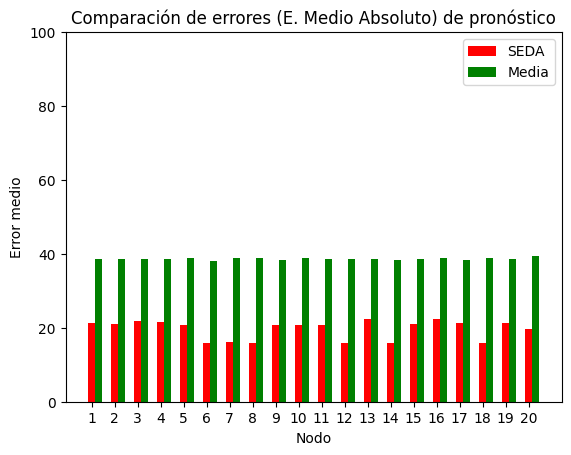

In [78]:
# Gráficos de barra comparando el error de pronóstico con el error de la media

ax = plt.subplot(111)
indices = np.arange(1, len(data)+1)

ancho = 0.3

ax.bar(indices, [np.mean(data[_][1]) for _ in depots], width = ancho, label = 'SEDA', color = 'red')
ax.bar(indices+ancho, [np.mean(data[_][2]) for _ in depots], width = ancho, label = 'Media', color='green')
ax.set_xticks(np.arange(1,len(data)+1))
ax.set_xticklabels([_ for _ in range(1,len(data)+1)])
ax.set_xlabel('Nodo')
ax.set_ylabel('Error medio')
ax.set_ylim(0,100)
ax.set_title('Comparación de errores (E. Medio Absoluto) de pronóstico')
ax.legend()
plt.show()


In [73]:
# nodo = 'N_1'
# for _ in range(1,10):
#     theta = _/10
#     # demandas = {'R': [], 'P': []}
#     error = []
#     mu = np.mean(historia[nodo])
#     sd = np.std(historia[nodo])
#     for t in tpo:
#         if t < 100:
#             d_real = datos[nodo][t]
#             pron = None
#         else:
#             d_real = datos[nodo][t]
#             pron = pronostico_SEDA(historia[nodo], T = 1, pron = True, alpha=0.9, beta=0.3, theta=theta)[0]
#             error_t = 100*abs(d_real - pron)/d_real

#             historia[nodo].append(d_real)
#             error.append(error_t)


#     print(f'theta = {theta} | Error promedio: {np.mean(error)}%')

N_4


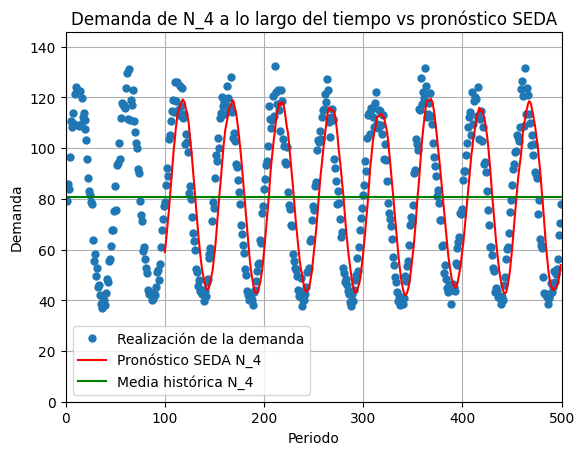

In [90]:
nodo = random.choice(depots)
demandas, error, error_mu = data[nodo]

print(nodo)
fig, ax = plt.subplots()
ax.set(xlabel='Periodo', ylabel='Demanda', title=f'Demanda de {nodo} a lo largo del tiempo vs pronóstico SEDA')
ax.grid()
ax.plot(tpo, demandas['R'], 'o', label='Realización de la demanda', markersize=5)
ax.plot(tpo, demandas['P'], 'r', label=f'Pronóstico SEDA {nodo}')
ax.plot(tpo, [np.mean(demandas['R'])]*len(tpo), 'g', label=f'Media histórica {nodo}')
ax.legend()
ax.set_xlim(0, T)
ax.set_ylim(0, max(demandas['R'])*1.1)
plt.show()
